# Cleaning and pre-processing of Airbnb data 

### Importing the libraries and data

In [1]:
from sagemaker import get_execution_role
role = get_execution_role()

In [2]:
!pip install geopandas
!pip install xgboost
!pip install pydot

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/bin/python -m pip install --upgrade pip' command.
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/secretstorage/util.py:25: Crypto

In [3]:
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import seaborn as sns
import geopandas as gpd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from statsmodels.tsa.seasonal import seasonal_decompose

Using TensorFlow backend.


In [4]:
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows', 100)

In [5]:
airbnb_df = pd.read_csv('s3://divyam-personal/divyam/listings_london.csv.gz')

In [6]:
airbnb_df.shape

(24462, 106)

### Dropping columns to be ignored

In [7]:
cols_to_drop = ['listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_location', 'host_about', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_verifications', 'calendar_last_scraped']
airbnb_df.drop(cols_to_drop, axis=1, inplace=True)

Checking null values

In [8]:
airbnb_df.isna().sum()

id                                                  0
experiences_offered                                 0
host_since                                         40
host_response_time                              10610
host_response_rate                              10610
host_acceptance_rate                            24462
host_is_superhost                                  40
host_listings_count                                40
host_total_listings_count                          40
host_has_profile_pic                               40
host_identity_verified                             40
street                                              0
neighbourhood                                       0
neighbourhood_cleansed                              0
neighbourhood_group_cleansed                        0
city                                                9
state                                             135
zipcode                                           547
market                      

In [9]:
#dropping columns with null values
airbnb_df.drop(['host_acceptance_rate', 'neighbourhood_group_cleansed', 'square_feet', 'weekly_price', 'monthly_price', 'license', 'jurisdiction_names'], axis=1, inplace=True)

host_listings_count and host_total_listings_count are the same in all but 248 cases. These cases are those where the value is NaN. Therefore one of these columns can be dropped. Other columns which split these into type of property will also be dropped, as they will be highly correlated (one will be the total of the others).

In [10]:
airbnb_df.loc[((airbnb_df.host_listings_count == airbnb_df.host_total_listings_count) == False)]

,id,experiences_offered,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
1139,1528556,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Berlin, Berlin, Germany",Moabit,Moabit Ost,Berlin,Berlin,10559,Berlin,"Berlin, Germany",DE,Germany,52.53066,13.34488,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,Elevator,""Buzzer/wirele...",$45.00,NaN,NaN,2,$20.00,2,1125,2,2,1125,1125,2.0,1125.0,49 months ago,t,0,0,0,0,3,0,2015-06-08,2015-08-17,100.0,10.0,9.0,10.0,10.0,9.0,9.0,t,f,f,flexible,f,f,1,0,1,0,0.06
2106,3662999,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Berlin, Berlin, Germany",Kreuzberg,Tempelhofer Vorstadt,Berlin,Berlin,10967,Berlin,"Berlin, Germany",DE,Germany,52.49302,13.41829,t,Apartment,Entire home/apt,2,1.0,1.0,1.0,Futon,"{TV,Internet,Wifi,Kitchen,""Smoking allowed"",""P...",$70.00,NaN,$30.00,1,$0.00,2,1125,2,2,1125,1125,2.0,1125.0,49 months ago,t,0,0,0,0,2,0,2014-08-31,2015-08-26,100.0,10.0,10.0,10.0,10.0,10.0,10.0,t,f,f,flexible,f,f,1,1,0,0,0.03
2987,5182410,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Berlin, Berlin, Germany",Neukölln,Reuterstraße,Berlin,Berlin,12047,Berlin,"Berlin, Germany",DE,Germany,52.49077,13.43162,f,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,Heating,Washer,Essentia...",$30.00,NaN,NaN,1,$0.00,3,21,3,3,21,21,3.0,21.0,38 months ago,t,0,0,0,0,3,0,2016-03-30,2016-09-25,100.0,10.0,9.0,9.0,10.0,10.0,9.0,t,t,f,moderate,f,f,1,0,1,0,0.07
3641,6489355,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Berlin, Berlin, Germany",Kreuzberg,Tempelhofer Vorstadt,Berlin,Berlin,10965,Berlin,"Berlin, Germany",DE,Germany,52.49347,13.37923,f,Apartment,Entire home/apt,4,1.0,1.0,2.0,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,Elevator,...",$65.00,$250.00,$30.00,1,$10.00,2,1125,2,2,1125,1125,2.0,1125.0,47 months ago,t,0,0,0,0,16,0,2015-07-05,2015-11-08,88.0,8.0,9.0,9.0,10.0,10.0,8.0,t,t,f,moderate,f,f,1,1,0,0,0.31
3776,6692587,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Berlin, Berlin, Germany",Prenzlauer Berg,Prenzlauer Berg Nordwest,Berlin,Berlin,10437,Berlin,"Berlin, Germany",DE,Germany,52.54367,13.41180,t,Apartment,Private room,2,1.5,1.0,1.0,Real Bed,"{TV,Internet,Wifi,Kitchen,""Smoking allowed"",""H...",$55.00,NaN,$19.00,1,$0.00,3,1125,3,3,1125,1125,3.0,1125.0,48 months ago,t,0,0,0,0,1,0,2015-08-02,2015-08-02,100.0,10.0,8.0,10.0,10.0,10.0,10.0,t,f,f,flexible,f,f,1,0,1,0,0.02
3787,6710453,none,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Berlin, Berlin, Germany",Neukölln,Reuterstraße,Berlin,Berlin,12045,Berlin,"Berlin, Germany",DE,Germany,52.48327,13.43525,t,Townhouse,Private room,2,1.0,1.0,1.0,Real Bed,"{Internet,Wifi,Kitchen,Washer,Essentials}",$30.00,$100.00,$15.00,1,$10.00,1,1125,1,1,1125,1125,1.0,1125.0,53 months ago,t,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,f,flexible,f,f,1,0,1,0,NaN
3834,6798392,none,NaN,Na

In [11]:
airbnb_df.drop(['host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms'], axis=1, inplace=True)

In [12]:
airbnb_df.drop(['minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm'], axis=1, inplace=True)

In [13]:
lat_long = airbnb_df[['latitude', 'longitude']]

In [14]:
airbnb_df.drop(['zipcode', 'latitude', 'longitude', 'street', 'neighbourhood', 'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'is_location_exact'], axis=1, inplace=True)

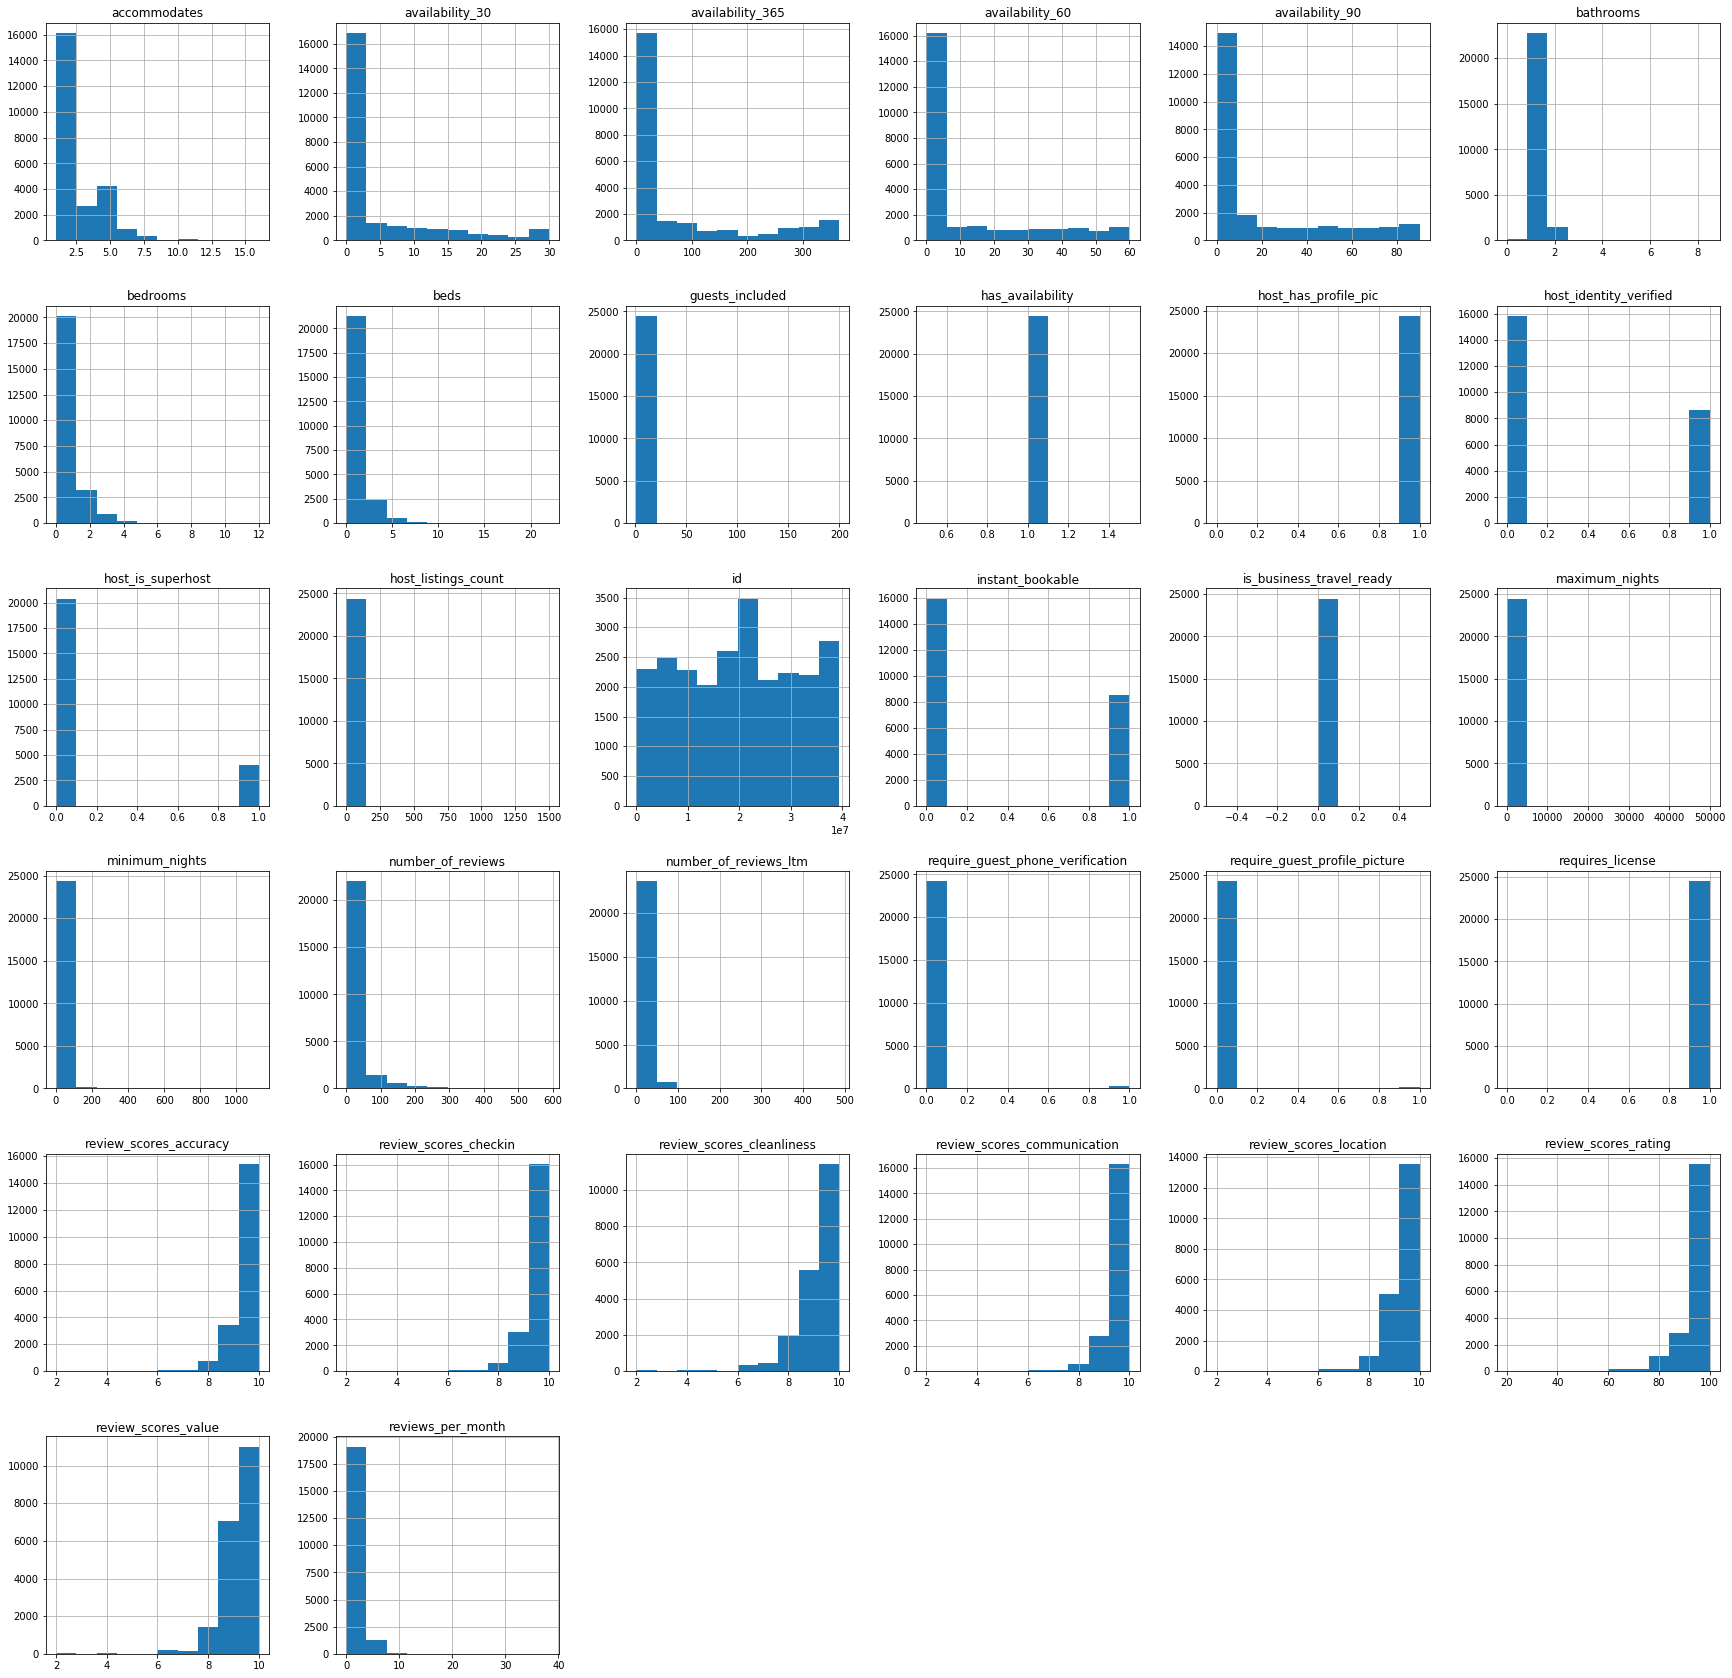

In [15]:
# Replacing columns with f/t with 0/1
airbnb_df.replace({'f': 0, 't': 1}, inplace=True)

airbnb_df.hist(figsize=(30,30));

From the above, it can be seen that several columns only contain one category and can be dropped:

In [16]:
airbnb_df.drop(['has_availability', 'host_has_profile_pic', 'is_business_travel_ready', 'require_guest_phone_verification', 'require_guest_profile_picture', 'requires_license'], axis=1, inplace=True)

**experiences_offered**

No eperiences offered for most of the listings

In [17]:
airbnb_df.experiences_offered.value_counts()

none    24462
Name: experiences_offered, dtype: int64

In [18]:
airbnb_df.drop('experiences_offered', axis=1, inplace=True)

**host_since**
a measure of the number of days that a host has been on the platform

In [19]:
# Converting to datetime
airbnb_df.host_since = pd.to_datetime(airbnb_df.host_since) 

# Calculating the number of days
airbnb_df['host_days_active'] = (datetime(2019, 9, 15) - airbnb_df.host_since).astype('timedelta64[D]')

# Printing mean and median
print("Mean days as host:", round(airbnb_df['host_days_active'].mean(),0))
print("Median days as host:", airbnb_df['host_days_active'].median())

# Replacing null values with the median
airbnb_df.host_days_active.fillna(airbnb_df.host_days_active.median(), inplace=True)

Mean days as host: 1533.0
Median days as host: 1525.0


**host_response_time**

In [20]:
airbnb_df.host_response_time.fillna("unknown", inplace=True)
airbnb_df.host_response_time.value_counts()

unknown               10610
within an hour         7512
within a few hours     3013
within a day           2790
a few days or more      537
Name: host_response_time, dtype: int64

In [21]:
airbnb_df.host_response_time.value_counts()

unknown               10610
within an hour         7512
within a few hours     3013
within a day           2790
a few days or more      537
Name: host_response_time, dtype: int64

**host_response_rate**

In [22]:
airbnb_df.host_response_rate = airbnb_df.host_response_rate.str[:-1].astype('float64')

In [23]:
# Bin into four categories
airbnb_df.host_response_rate = pd.cut(airbnb_df.host_response_rate, bins=[0, 50, 90, 99, 100], labels=['0-49%', '50-89%', '90-99%', '100%'], include_lowest=True)

# Converting to string
airbnb_df.host_response_rate = airbnb_df.host_response_rate.astype('str')

# Replace nulls with 'unknown'
airbnb_df.host_response_rate.replace('nan', 'unknown', inplace=True)

# Category counts
airbnb_df.host_response_rate.value_counts()

unknown    10610
100%        9743
50-89%      2555
0-49%        787
90-99%       767
Name: host_response_rate, dtype: int64

**host_is_superhost**

In [24]:
airbnb_df.dropna(subset=['host_since'], inplace=True)

**property_type**

In [25]:
airbnb_df.property_type.value_counts()

Apartment                 21652
Condominium                 660
House                       486
Loft                        480
Serviced apartment          280
Hostel                      186
Townhouse                   121
Hotel                        91
Boutique hotel               87
Guest suite                  69
Guesthouse                   65
Bed and breakfast            45
Other                        31
Bungalow                     25
Villa                        19
Houseboat                    18
Boat                         17
Aparthotel                   13
Casa particular (Cuba)       13
Tiny house                   12
Camper/RV                    11
Cottage                       8
Pension (South Korea)         8
Cabin                         7
Barn                          5
Treehouse                     3
Castle                        3
Earth house                   2
Cave                          1
Vacation home                 1
Resort                        1
Lighthou

Look properly

In [26]:
# Replacing categories that are types of houses or apartments or hotels
airbnb_df.property_type.replace({
    'Townhouse': 'House',
    'Serviced apartment': 'Apartment',
    'Aparthotel':'Apartment',
    'Condominium':'Apartment',
    'Loft': 'Apartment',
    'Bungalow': 'House',
    'Cottage': 'House',
    'Villa': 'House',
    'Tiny house': 'House',
    'Earth house': 'House',
    'Chalet': 'House',
    'Boutique hotel':'Hotel'
    }, inplace=True)

# Replacing other categories with 'other'
airbnb_df.loc[~airbnb_df.property_type.isin(['House', 'Apartment','Hotel']), 'property_type'] = 'Other'

**bathrooms, bedrooms and beds**

In [27]:
for col in ['bathrooms', 'bedrooms', 'beds']:
    airbnb_df[col].fillna(airbnb_df[col].median(), inplace=True)

**bed_type**

In [28]:
airbnb_df.bed_type.value_counts()

Real Bed         23740
Pull-out Sofa      396
Futon              207
Couch               61
Airbed              18
Name: bed_type, dtype: int64

In [29]:
airbnb_df.drop('bed_type', axis=1, inplace=True)

**amenities**

In [30]:
# Creating a set of all possible amenities
amenities_list = list(airbnb_df.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
amenities_set

{'',
 '24-hour check-in',
 'Accessible-height bed',
 'Accessible-height toilet',
 'Air conditioning',
 'Air purifier',
 'BBQ grill',
 'Baby bath',
 'Baby monitor',
 'Babysitter recommendations',
 'Balcony',
 'Bath towel',
 'Bathroom essentials',
 'Bathtub',
 'Bathtub with bath chair',
 'Beach essentials',
 'Beach view',
 'Beachfront',
 'Bed linens',
 'Bedroom comforts',
 'Bidet',
 'Body soap',
 'Breakfast',
 'Breakfast table',
 'Building staff',
 'Buzzer/wireless intercom',
 'Cable TV',
 'Carbon monoxide detector',
 'Cat(s)',
 'Ceiling fan',
 'Ceiling hoist',
 'Changing table',
 'Children’s books and toys',
 'Children’s dinnerware',
 'Cleaning before checkout',
 'Coffee maker',
 'Convection oven',
 'Cooking basics',
 'Crib',
 'DVD player',
 'Day bed',
 'Disabled parking spot',
 'Dishes and silverware',
 'Dishwasher',
 'Dog(s)',
 'Doorman',
 'Double oven',
 'Dryer',
 'EV charger',
 'Electric profiling bed',
 'Elevator',
 'En suite bathroom',
 'Espresso machine',
 'Essentials',
 'Etherne

In [31]:
airbnb_df.loc[airbnb_df['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Amazon Echo|Apple TV|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('BBQ grill|Fire pit|Propane barbeque'), 'bbq'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Bed linens'), 'bed_linen'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('TV'), 'tv'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Cooking basics'), 'cooking_basics'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'white_goods'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Elevator'), 'elevator'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Exercise equipment|Gym|gym'), 'gym'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('parking'), 'parking'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Garden|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Sauna|Pool|pool'), 'hot_tub_sauna_or_pool'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Pets|pet|Cat(s)|Dog(s)'), 'pets_allowed'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Safe|Security system'), 'secure'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
airbnb_df.loc[airbnb_df['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Look at closely- it can be done after we join all datasets - code to be copied from the existing notebook

One way to reduce the number of features (to avoid the curse of dimensionality) is to remove the amenities which add relatively little information, or are relatively unhelpful in differentiating between different listings. Amenity features where either the true or the false category contains fewer than 10% of listings will be removed.

**price**

In [32]:
airbnb_df.price = airbnb_df.price.str[1:-3]
airbnb_df.price = airbnb_df.price.str.replace(",", "")
airbnb_df.price = airbnb_df.price.astype('int64')

**security_deposit**

In [33]:
airbnb_df.security_deposit = airbnb_df.security_deposit.str[1:-3]
airbnb_df.security_deposit = airbnb_df.security_deposit.str.replace(",", "")
airbnb_df.security_deposit.fillna(0, inplace=True)
airbnb_df.security_deposit = airbnb_df.security_deposit.astype('int64')

**cleaning_fee**

In [34]:
airbnb_df.cleaning_fee = airbnb_df.cleaning_fee.str[1:-3]
airbnb_df.cleaning_fee = airbnb_df.cleaning_fee.str.replace(",", "")
airbnb_df.cleaning_fee.fillna(0, inplace=True)
airbnb_df.cleaning_fee = airbnb_df.cleaning_fee.astype('int64')

**extra_people**

In [35]:
airbnb_df.extra_people = airbnb_df.extra_people.str[1:-3]
airbnb_df.extra_people = airbnb_df.extra_people.str.replace(",", "")
airbnb_df.extra_people.fillna(0, inplace=True)
airbnb_df.extra_people = airbnb_df.extra_people.astype('int64')

In [36]:
airbnb_df.drop('calendar_updated', axis=1, inplace=True)

**first_review and last_review**

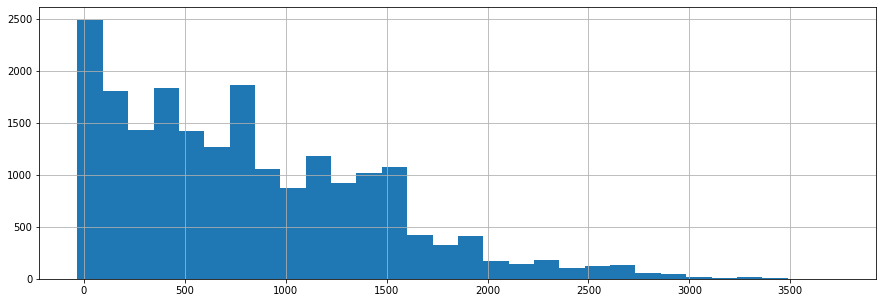

In [37]:
airbnb_df.first_review = pd.to_datetime(airbnb_df.first_review) # Converting to datetime

# Calculating the number of days between the first review and the date the data was scraped
airbnb_df['time_since_first_review'] = (datetime(2019, 9, 15) - airbnb_df.first_review).astype('timedelta64[D]')

# Distribution of the number of days since first review
airbnb_df.time_since_first_review.hist(figsize=(15,5), bins=30);

In [38]:
def bin_column(col, bins, labels, na_label='unknown'):
    airbnb_df[col] = pd.cut(airbnb_df[col], bins=bins, labels=labels, include_lowest=True)
    airbnb_df[col] = airbnb_df[col].astype('str')
    airbnb_df[col].fillna(na_label, inplace=True)

In [39]:
# Binning time since first review
bin_column('time_since_first_review',
           bins=[0, 182, 365, 730, 1460, max(airbnb_df.time_since_first_review)],
           labels=['0-6 months',
                   '6-12 months',
                   '1-2 years',
                   '2-3 years',
                   '4+ years'],
           na_label='no reviews')

The same process will be followed for last_review:

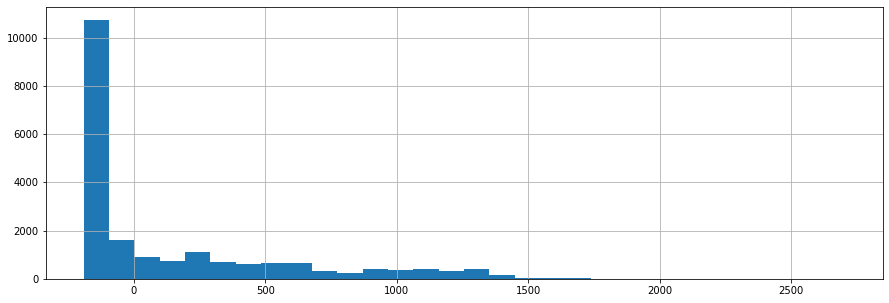

In [40]:
airbnb_df.last_review = pd.to_datetime(airbnb_df.last_review) # Converting to datetime

# Calculating the number of days between the most recent review and the date the data was scraped
airbnb_df['time_since_last_review'] = (datetime(2019, 4, 9) - airbnb_df.last_review).astype('timedelta64[D]')

# Distribution of the number of days since last review
airbnb_df.time_since_last_review.hist(figsize=(15,5), bins=30);

In [41]:
# Binning time since last review
bin_column('time_since_last_review',
           bins=[0, 14, 60, 182, 365, max(airbnb_df.time_since_last_review)],
           labels=['0-2 weeks',
                   '2-8 weeks',
                   '2-6 months',
                   '6-12 months',
                   '1+ year'],
           na_label='no reviews')

In [42]:
# Dropping last_review - first_review will be kept for EDA and dropped later
airbnb_df.drop('last_review', axis=1, inplace=True)

**review ratings columns**

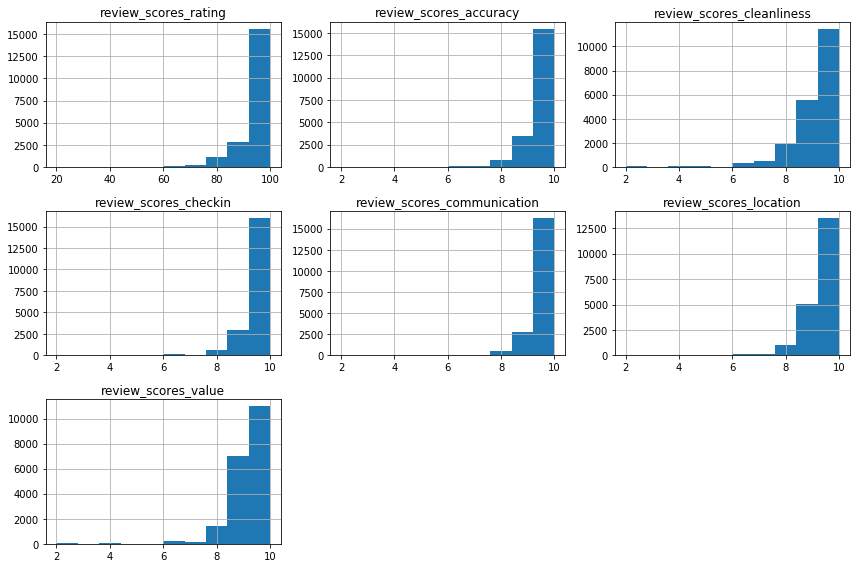

In [43]:
# Checking the distributions of the review ratings columns
variables_to_plot = list(airbnb_df.columns[airbnb_df.columns.str.startswith("review_scores") == True])
fig = plt.figure(figsize=(12,8))
for i, var_name in enumerate(variables_to_plot):
    ax = fig.add_subplot(3,3,i+1)
    airbnb_df[var_name].hist(bins=10,ax=ax)
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

In [44]:
# Creating a list of all review columns that are scored out of 10
variables_to_plot.pop(0)

'review_scores_rating'

In [45]:
# Binning for all columns scored out of 10
for col in variables_to_plot:
    bin_column(col,
               bins=[0, 8, 9, 10],
               labels=['0-8/10', '9/10', '10/10'],
               na_label='no reviews')

In [46]:
# Binning column scored out of 100
bin_column('review_scores_rating',
           bins=[0, 80, 95, 100],
           labels=['0-79/100', '80-94/100', '95-100/100'],
           na_label='no reviews')

**cancellation_policy**

In [47]:
airbnb_df.cancellation_policy.value_counts()

flexible                       9602
strict_14_with_grace_period    7359
moderate                       7308
super_strict_30                  76
super_strict_60                  75
strict                            2
Name: cancellation_policy, dtype: int64

Look at closely

In [48]:
# Replacing categories
airbnb_df.cancellation_policy.replace({
    'super_strict_30': 'strict_14_with_grace_period',
    'super_strict_60': 'strict_14_with_grace_period',
    'strict': 'strict_14_with_grace_period',
    'luxury_moderate': 'moderate'
    }, inplace=True)

**number_of_reviews_ltm and reviews_per_month**

In [49]:
airbnb_df.drop(['number_of_reviews_ltm', 'reviews_per_month'], axis=1, inplace=True)

***

# Exploratory data analysis

### Time series

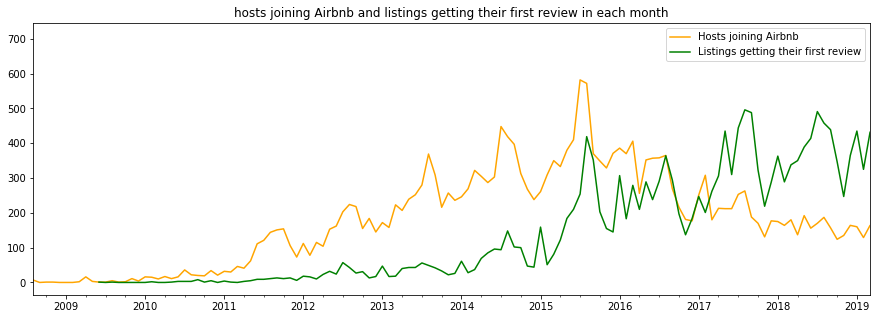

In [50]:
plt.figure(figsize=(15,5))
airbnb_df.set_index('host_since').resample('MS').size().plot(label='Hosts joining Airbnb', color='orange')
airbnb_df.set_index('first_review').resample('MS').size().plot(label='Listings getting their first review', color='green')
plt.title('hosts joining Airbnb and listings getting their first review in each month')
plt.legend()
plt.xlim('2008-08-01', '2019-03-31') # Limiting to whole months
plt.xlabel('')
plt.ylabel('')
plt.show()

In [51]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(airbnb_df.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(airbnb_df.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)

In [52]:
def decompose_time_series(df, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

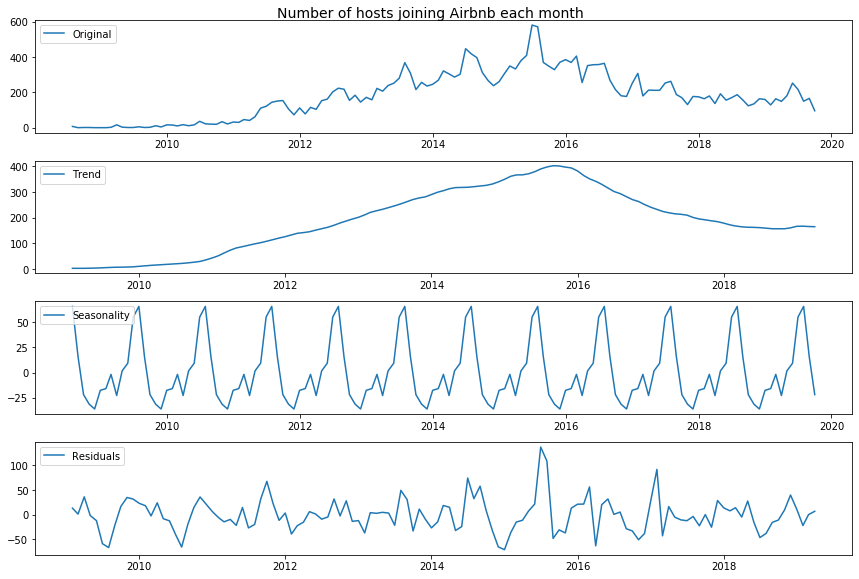

In [53]:
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

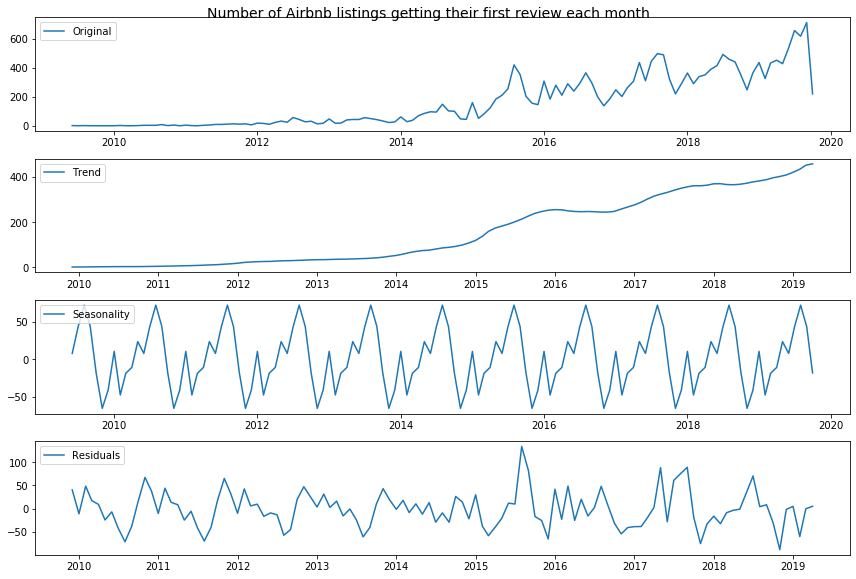

In [54]:
decompose_time_series(ts_first_review, title='Number of Airbnb listings getting their first review each month')

*Question: are the different patterns in the growth in the number of hosts and the number of listings due to hosts increasingly owning multiple properties?*

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


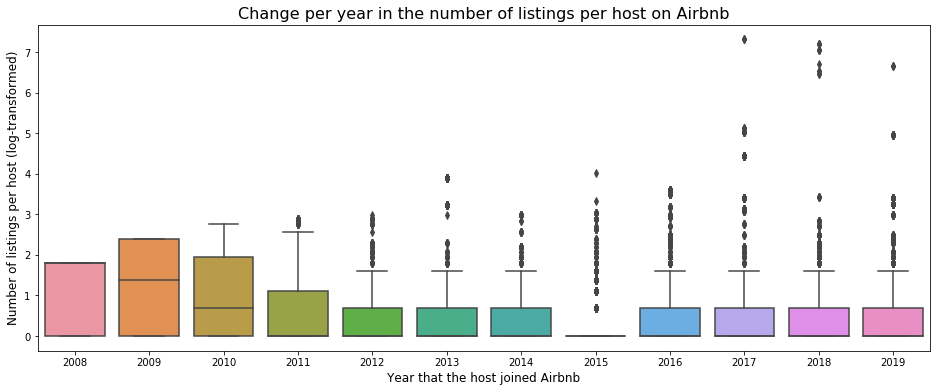

In [55]:
plt.figure(figsize=(16,6))
sns.boxplot(airbnb_df.host_since.dt.year, np.log(airbnb_df.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb', fontsize=16)
plt.show()

In [56]:
# List of the largest host_listings_count and the year the host joined Airbnb
airbnb_df.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]

,host_since,host_listings_count
12082,2017-07-20,153.0
23775,2017-07-20,168.0
20399,2017-01-24,169.0
16509,2018-06-14,635.0
19100,2018-09-03,685.0
20686,2019-01-13,782.0
19110,2018-09-03,813.0
19103,2018-09-03,1147.0
19101,2018-09-03,1324.0
15185,2017-03-22,1499.0


*Question: how have prices changed over time?*

/home/ec2-user/anaconda3/envs/amazonei_tensorflow_p36/lib/python3.6/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


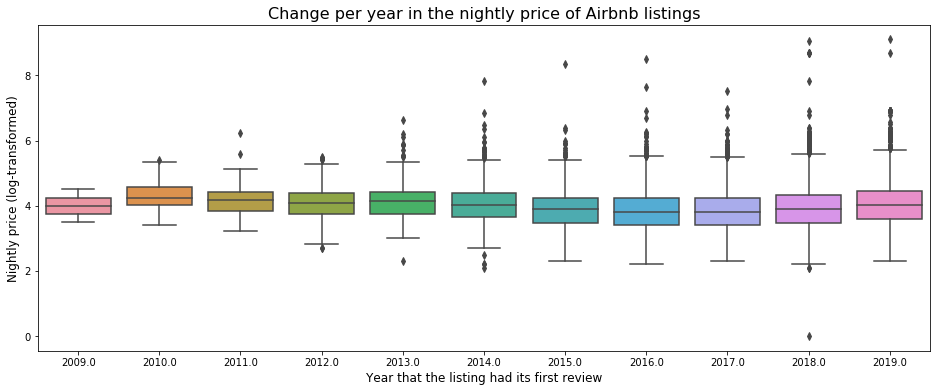

In [57]:
plt.figure(figsize=(16,6))
sns.boxplot(airbnb_df.first_review.dt.year, np.log(airbnb_df.price))
plt.xlabel('Year that the listing had its first review', fontsize=12)
plt.ylabel('Nightly price (log-transformed)', fontsize=12)
plt.title('Change per year in the nightly price of Airbnb listings', fontsize=16)
plt.show()

In [58]:
print("Mean nightly price of listings in each year on Airbnb:")
print(round(airbnb_df.set_index('first_review').price.resample('YS').mean(),2))

Mean nightly price of listings in each year on Airbnb:
first_review
2009-01-01    61.50
2010-01-01    86.46
2011-01-01    77.99
2012-01-01    68.64
2013-01-01    74.19
2014-01-01    73.21
2015-01-01    60.15
2016-01-01    62.81
2017-01-01    57.30
2018-01-01    70.30
2019-01-01    77.51
Name: price, dtype: float64


In [59]:
# Dropping host_since and first_review as they are no longer needed
airbnb_df.drop(['host_since', 'first_review'], axis=1, inplace=True)

### Numerical features

In [60]:
airbnb_df.describe()

,id,host_is_superhost,host_listings_count,host_identity_verified,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,instant_bookable,host_days_active,check_in_24h,air_conditioning,high_end_electronics,bbq,balcony,nature_and_views,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,gym,child_friendly,parking,outdoor_space,host_greeting,hot_tub_sauna_or_pool,internet,long_term_stays,pets_allowed,private_entrance,secure,self_check_in,smoking_allowed,accessible,event_suitable
count,2.442200e+04,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,24422.000000,1196.0,528.0,299.0,510.0,3623.0,604.0,6959.0,1304.0,11186.0,5648.0,7232.0,20459.0,5503.0,287.0,7563.0,9670.0,1179.0,6180.0,705.0,23470.0,3698.0,4002.0,3637.0,1834.0,1534.0,4572.0,1226.0,559.0
mean,1.995811e+07,0.165138,3.415936,0.352674,2.679265,1.101445,1.161207,1.620711,72.362829,119.875891,19.407420,1.365408,8.440955,7.112890,601.653837,4.321923,11.073581,18.579191,73.552535,21.017853,0.347760,1532.898739,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
std,1.131288e+07,0.371313,31.813198,0.477812,1.571764,0.350196,0.671091,1.219755,220.449598,317.764622,25.512711,1.551659,11.668823,25.971229,638.117876,7.741083,17.910705,27.722717,115.681675,43.922155,0.476269,784.714098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.944000e+03,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-31.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
25%,1.003811e+07,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,33.000000,0.000000,0.000000,1.000000,0.000000,2.000000,20.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,983.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
50%,2.024066e+07,0.000000,1.000000,0.000000,2.000000,1.000000,1.000000,1.000000,50.000000,0.000000,10.000000,1.000000,5.000000,3.000000,1123.000000,0.000000,0.000000,0.000000,1.000000,5.000000,0.000000,1525.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
75%,2.958102e+07,0.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000,76.000000,120.000000,30.000000,1.000000,15.000000,4.000000,1125.000000,6.000000,18.000000,33.000000,104.000000,18.000000,1.000000,2088.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
max,3.941083e+07,1.000000,1499.000000,1.000000,16.000000,8.500000,12.000000,22.000000,8983.000000,4556.000000,500.000000,200.000000,250.000000,1124.000000,50000.000000,30.000000,60.000000,90.000000,365.000000,589.000000,1.000000,4048.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


**Price**

*Question: what is the overall distribution of prices?*

In [61]:
print(f"Nightly advertised prices range from {min(airbnb_df.price)} to {max(airbnb_df.price)}.")

Nightly advertised prices range from 0 to 8983.


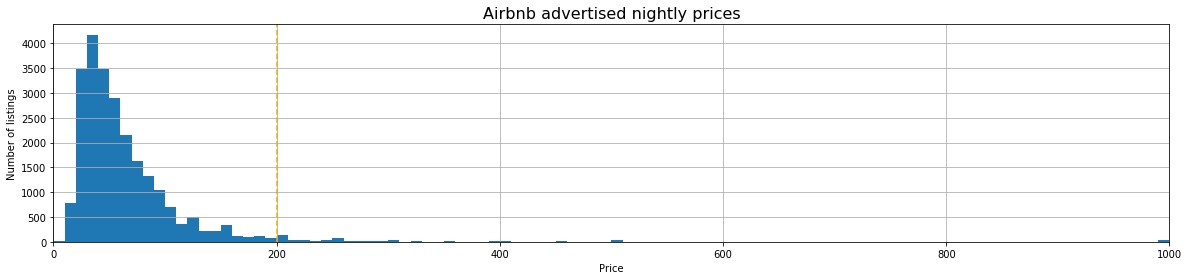

In [62]:
plt.figure(figsize=(20,4))
airbnb_df.price.hist(bins=100, range=(0,1000))
plt.margins(x=0)
plt.axvline(200, color='orange', linestyle='--')
plt.title("Airbnb advertised nightly prices", fontsize=16)
plt.xlabel("Price")
plt.ylabel("Number of listings")
plt.show()

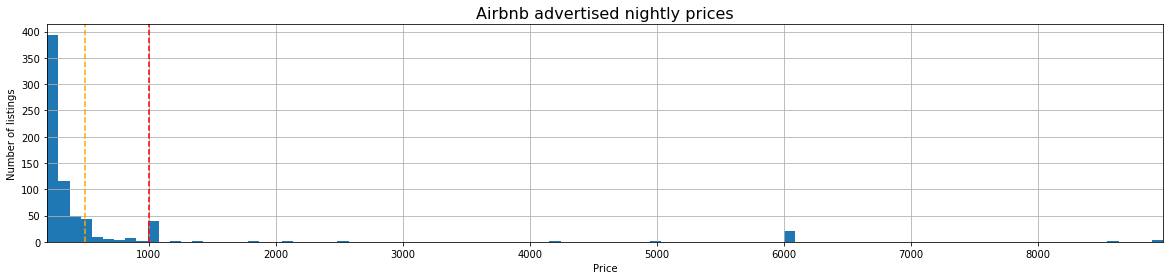

In [63]:
plt.figure(figsize=(20,4))
airbnb_df.price.hist(bins=100, range=(200, max(airbnb_df.price)))
plt.margins(x=0)
plt.axvline(500, color='orange', linestyle='--')
plt.axvline(1000, color='red', linestyle='--')
plt.title("Airbnb advertised nightly prices", fontsize=16)
plt.xlabel("Price")
plt.ylabel("Number of listings")
plt.show()

**Host listings count**

*Question: how many listings do hosts have on average? How many multi-listing hosts are there?*

In [64]:
print("Median number of listings per host:", int(airbnb_df.host_listings_count.median()))
print("Mean number of listings per host:", int(round(airbnb_df.host_listings_count.mean())))
print(f"{int(round(100*len(airbnb_df[airbnb_df.host_listings_count == 1])/len(airbnb_df)))}% of listings are from hosts with one listing.")

Median number of listings per host: 1
Mean number of listings per host: 3
65% of listings are from hosts with one listing.


**Number of people accommodated, bathrooms, bedrooms and beds**

*Question: what are the average number of people accommodated, bathrooms, bedrooms and beds in Airbnb listings in London, and how do prices differ?*

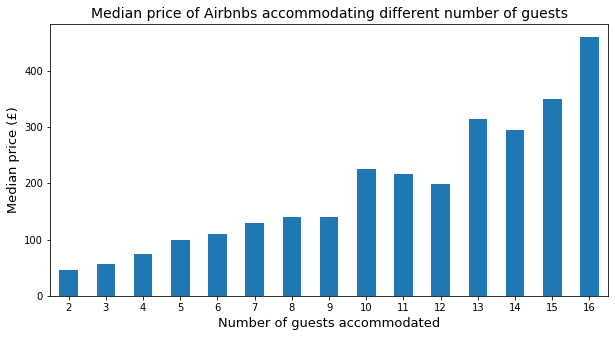

In [65]:
plt.figure(figsize=(10,5))
airbnb_df.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (£)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

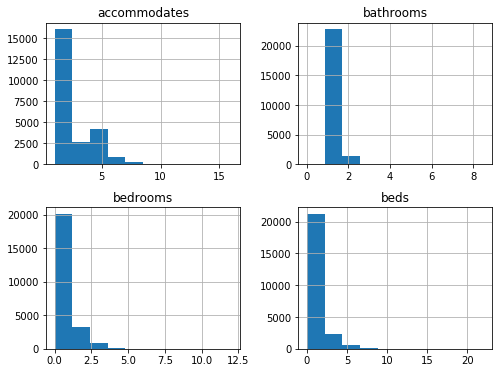

In [66]:
airbnb_df[['accommodates', 'bathrooms', 'bedrooms', 'beds']].hist(figsize=(8,6));

### Categorical features

Categorical features will be explored and plotted, to gain insights and to determine whether or not they should be included in the final model.

**Neighbourhood**

*Question: which areas have the most Airbnb properties, and which are the most expensive?* 

In [67]:
# Renaming the neighbourhood column
airbnb_df.rename(columns={'neighbourhood_cleansed': 'borough'}, inplace=True)

# Importing the London borough boundary GeoJSON file as a dataframe in geopandas
map_df = gpd.read_file('london_neighbourhoods.geojson')
map_df.head()

,neighbourhood,neighbourhood_group,geometry
0,Blankenfelde/Niederschönhausen,Pankow,"MULTIPOLYGON (((13.41191 52.61487, 13.41183 52..."
1,Helmholtzplatz,Pankow,"MULTIPOLYGON (((13.41405 52.54929, 13.41422 52..."
2,Wiesbadener Straße,Charlottenburg-Wilm.,"MULTIPOLYGON (((13.30748 52.46788, 13.30743 52..."
3,Schmöckwitz/Karolinenhof/Rauchfangswerder,Treptow - Köpenick,"MULTIPOLYGON (((13.70973 52.39630, 13.70926 52..."
4,Müggelheim,Treptow - Köpenick,"MULTIPOLYGON (((13.73762 52.40850, 13.73773 52..."


In [68]:
# Dropping the empty column
map_df.drop('neighbourhood_group', axis=1, inplace=True)

# Creating a dataframe of listing counts and median price by borough
borough_df = pd.DataFrame(airbnb_df.groupby('borough').size())
borough_df.rename(columns={0: 'number_of_listings'}, inplace=True)
borough_df['median_price'] = airbnb_df.groupby('borough').price.median().values

# Joining the dataframes
borough_map_df = map_df.set_index('neighbourhood').join(borough_df)

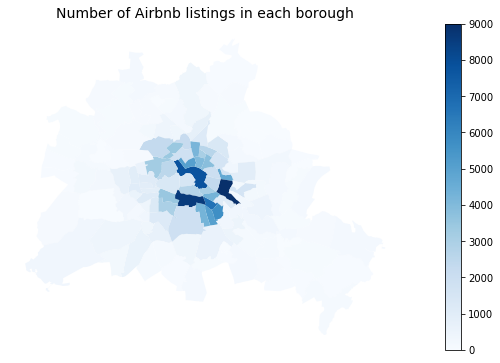

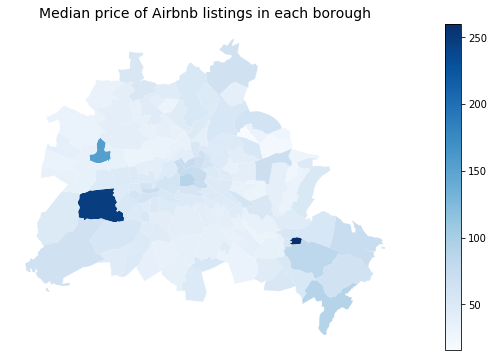

In [69]:
# Plotting the number of listings in each borough
fig1, ax1 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='number_of_listings', cmap='Blues', ax=ax1)
ax1.axis('off')
ax1.set_title('Number of Airbnb listings in each borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=9000))
sm._A = [] # Creates an empty array for the data range
cbar = fig1.colorbar(sm)
plt.show()

# Plotting the median price of listings in each borough
fig2, ax2 = plt.subplots(1, figsize=(15, 6))
borough_map_df.plot(column='median_price', cmap='Blues', ax=ax2)
ax2.axis('off')
ax2.set_title('Median price of Airbnb listings in each borough', fontsize=14)
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=min(borough_map_df.median_price), vmax=max(borough_map_df.median_price)))
sm._A = [] # Creates an empty array for the data range
cbar = fig2.colorbar(sm)
plt.show()

**Property and room types**

*Question: what are the most common property and room types?*

In [70]:
def category_count_plot(col, figsize=(8,4)):
    plt.figure(figsize=figsize)
    airbnb_df[col].value_counts().plot(kind='bar')
    plt.title(col)
    plt.xticks(rotation=0)
    plt.show()

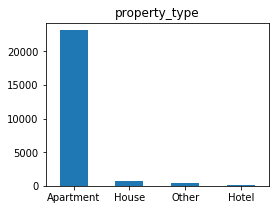

Apartment    0.945254
House        0.027557
Other        0.019900
Hotel        0.007289
Name: property_type, dtype: float64


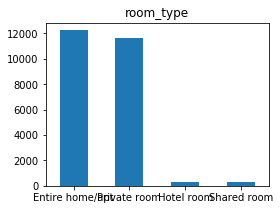

Entire home/apt    0.500369
Private room       0.475227
Hotel room         0.012407
Shared room        0.011997
Name: room_type, dtype: float64


In [71]:
for col in ['property_type', 'room_type']:
    category_count_plot(col, figsize=(4,3))
    print(airbnb_df[col].value_counts(normalize=True))

**Reviews**

*Question: what is the distribution of reviews like?*

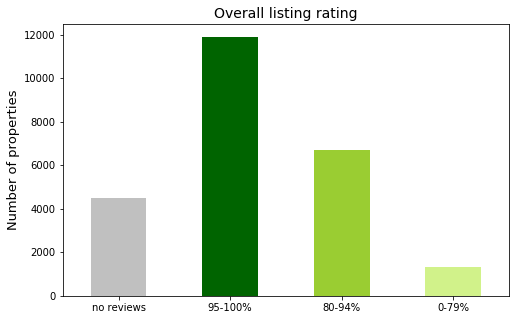

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.set_title('Overall listing rating', fontsize=14)
airbnb_df['review_scores_rating'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['silver', 'darkgreen', 'yellowgreen', '#d1f28a' ], ax=ax)
ax.set_xticklabels(labels=['no reviews', '95-100%', '80-94%', '0-79%'], rotation=0)
ax.set_xlabel('')
ax.set_ylabel('Number of properties', fontsize=13)
plt.show()

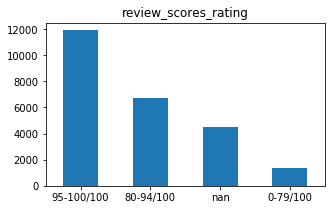

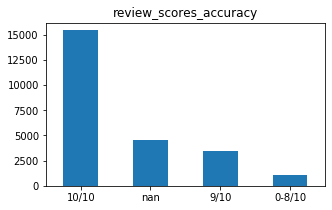

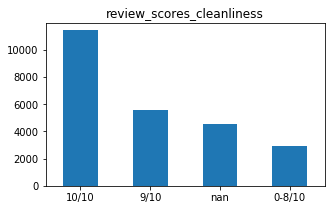

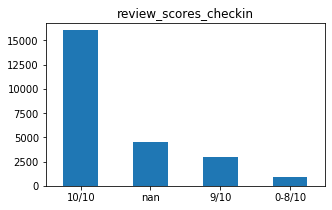

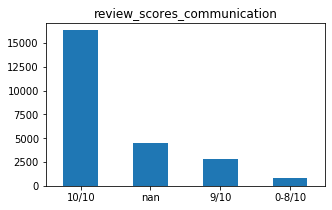

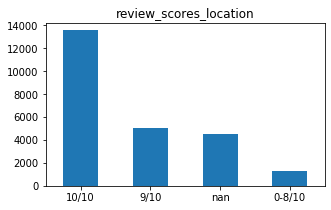

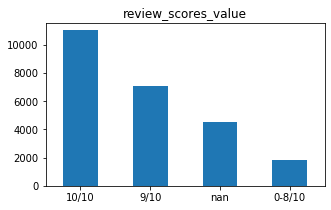

In [73]:
for col in list(airbnb_df.columns[airbnb_df.columns.str.startswith("review_scores") == True]):
    category_count_plot(col, figsize=(5,3))

**First and last reviews**

*Question: how long have listings been on the site, and how many listings have been reviewed recently?*

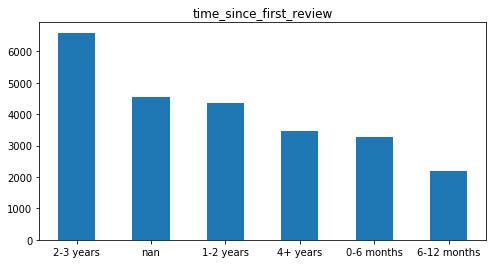

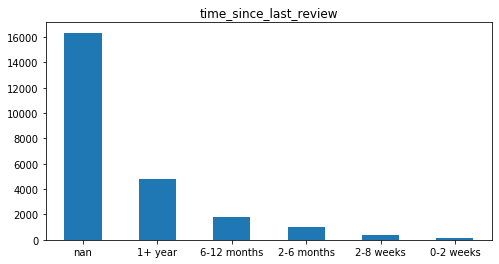

In [74]:
for col in ['time_since_first_review', 'time_since_last_review']:
    category_count_plot(col)

### Boolean  features

In [75]:
def binary_count_and_price_plot(col, figsize=(8,3)):
    """
    Plots a simple bar chart of the counts of true and false categories in the column specified,
    next to a bar chart of the median price for each category.
    A figure size can optionally be specified.
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle(col, fontsize=16, y=1)
    plt.subplots_adjust(top=0.80) # So that the suptitle does not overlap with the ax plot titles
    
    airbnb_df.groupby(col).size().plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'])
    ax1.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax1.set_title('Category count')
    ax1.set_xlabel('')
    
    airbnb_df.groupby(col).price.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'])
    ax2.set_xticklabels(labels=['false', 'true'], rotation=0)
    ax2.set_title('Median price (£)')
    ax2.set_xlabel('')
    
    plt.show()

**Superhosts**

*Question: what proportion of Airbnb hosts are superhosts, and is it worth being one? (a question often asked by hosts)*

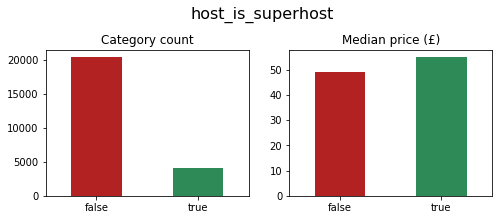

In [76]:
binary_count_and_price_plot('host_is_superhost')

**Amenities**

*Question: which amenities are common, and which increase the price of an Airbnb listing?*

Answer: amenities can be split into four main groups:

Uncommon, but properties with it have a higher median price:
- Balcony
- Bed linen
- Coffee machine
- Basic cooking equipment
- Elevator
- Child friendly
- Outdoor space
- Long term stays allowed
- Private entrance
- Safe or security system
- Self check-in

Most properties have it, and properties with it have a higher median price:
- TV
- Washer, dryer and/or dishwasher

Most properties have it, and there is no major difference in price between properties with and without it:
- Internet

Uncommon, and properties with it have a lower median price:
- Breakfast (probably because these are bed & breakfasts and therefore single rooms rather than entire homes)
- Parking (presumably because these are less likely to be central properties)
- Greeted by host (surprisingly!)
- Pets allowed

The takeaway from this is that there are some things that Airbnb hosts can do to try and improve their listing's price, although there is often not a simple causative relationship (e.g. having a parking space might improve your price, but listings with parking spaces are cheaper on average because they are less likely to be in central London, and location is a more important factor than parking space):
- **Make sure you have the necessities that your competitors also have**, e.g. internet, a TV and white goods (a washer, dryer and/or dishwasher).
- If you can, **include some extras to make your property stand out and achieve a higher price**. For example, you could buy a coffee machine, allow self check-in and long-term stays, and make your property child-friendly.
- **Avoid pets** as the additional wear and tear to your property might harm its financial performance.

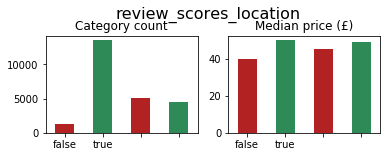

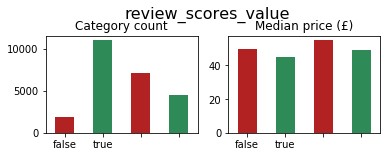

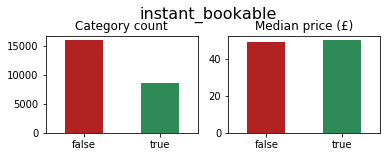

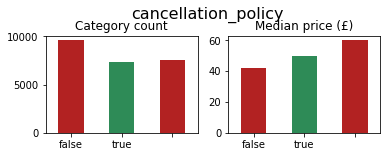

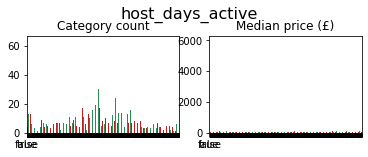

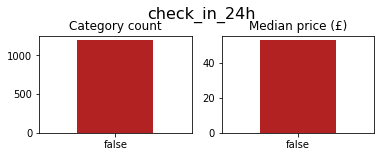

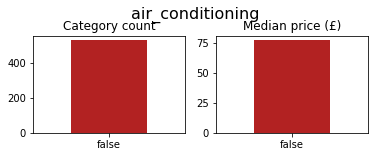

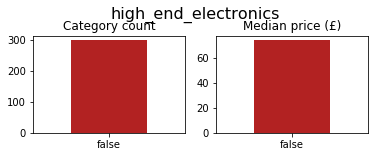

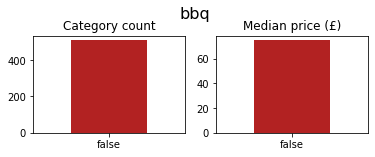

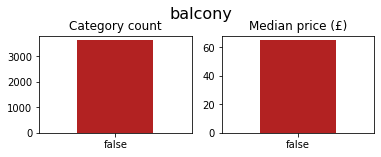

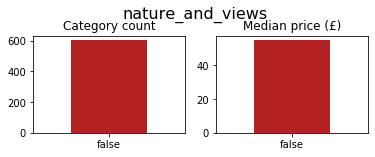

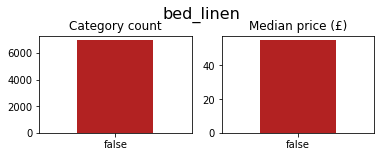

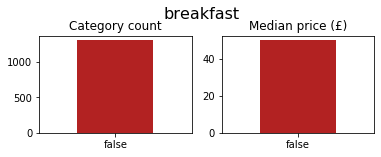

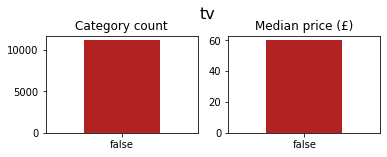

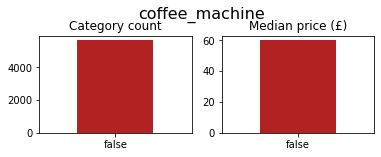

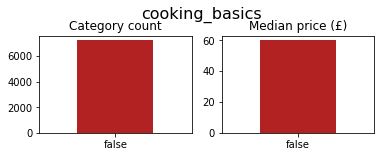

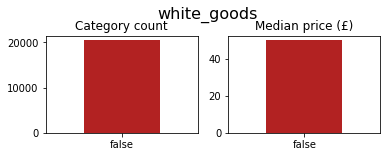

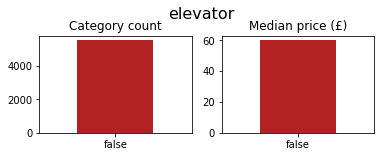

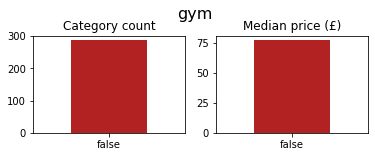

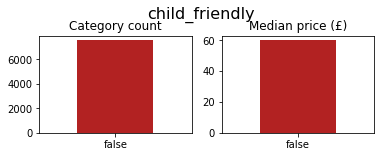

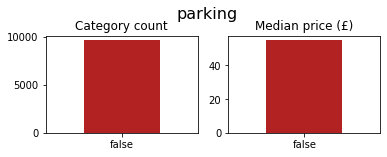

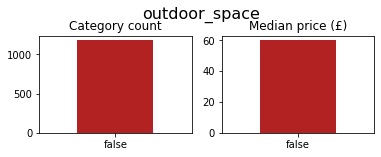

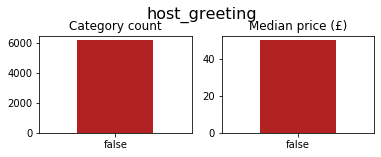

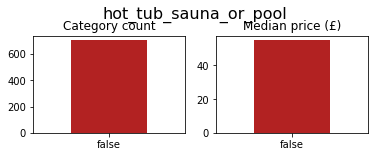

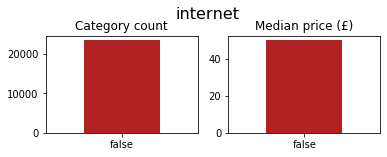

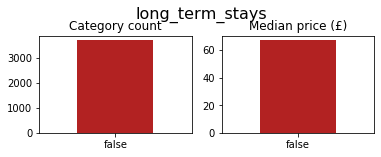

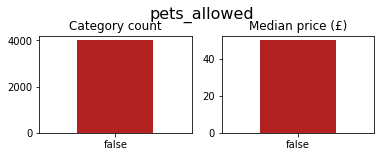

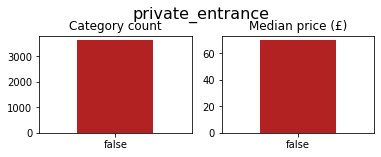

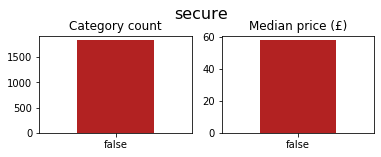

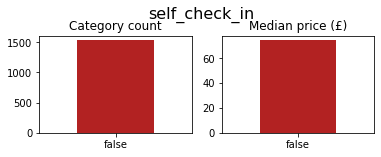

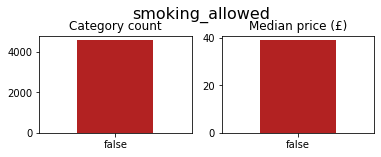

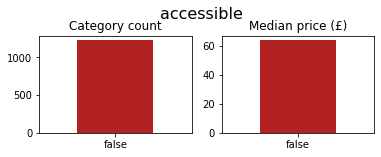

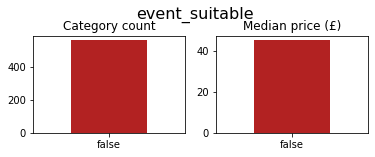

In [77]:
for col in airbnb_df.iloc[:,31:-2].columns:
    binary_count_and_price_plot(col, figsize=(6,2))

In [78]:
#airbnb_df.to_csv("london_cleaned.csv.gz", index=False)